# Computational Geomechanics: Homework
# Pressurization of a fracure in a poroelastic medium

Axel Giboulot

axel.giboulot@epfl.ch

SCIPER: 316215

## Problem description

A wellbore introduces a fluid inside a rock's fracture with a certain pressure $p_w$. Said rock is supposed to be of infinite extent. The fracture's radius $R$ is fixed but not its width $w$. The thin wellbore is supposed to be thin in comparison to the fracture and the fracture is perfectly axisymmetric around said wellbore.

![Image not found](figures/sketch.png "Sketch of the problem.")


The drained and undrained responses are examined for the following two cases where the fracture loading is fast:
1. Impermeable fracture walls.
2. Permeable fracture walls.

## Method of solution

To solve this problem, a poroelastic applied, building a coupled hydro-mechanical model. A first search for the undrained response is done and used as the starting point of a transient analysis. The latter ends with the drained solution.

The effects of the injected pressure are considered to be similiar to a surface traction normal to the fracture's surface and a pore pressure condition for the permeable case. The effects of the pressure gradient on the surface traction is not considered in this exercise.

No initial stresses are applied, all values computed here are deviations from the hypothetical inital stresses.

In [1]:
import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pygmsh

from utils.MesherWrapper import Mesh
from utils.MeshUtils import MeshUtils
from utils import MatrixAssembly
from utils import PoroElasticProperties as prop

In [2]:
### Problem variables ###
# Mechanical actions
fracture_pressure = 1e-6  # MPa
# Geometry
fracture_radius = 1
height = 50 * fracture_radius
width = 50 * fracture_radius

time = np.logspace(-5, 30, num=3)

## Material properties

The rock is modelled as poroelastic to consider the effects of the water pressure variation.

\begin{equation}
\sigma_{ij}= 2G\varepsilon_{ij} + (K-2G/3)\varepsilon_{kk}\delta_{ij} - \alpha p\delta_{ij}
\end{equation}

The density of the rock as well as the density of the water are not accounted for in this exercise since no loads will be acconted for, only deviations from the equilibrium state are used and computed in this exercise.

In [3]:
k = 8.4e3  # elastic drained bulk modulus [MPa]
G = 6.8e3  # shear modulus [MPa]
alpha = 0.707692  # biot coefficient
M = 1e6  # biot modulus [MPa]

perm = 1e-19  # permeability  # m^2
mu_f = 1e-3  # fluid viscosity
rho = 1e3  # density  # kg/m3
kappa = perm / mu_f  # conductivity (mobility?)
k_u = prop.undrained_bulk_modulus(k, alpha, M)
print(f"K    = {kappa*rho*9.81/mu_f * 365.25*24*3600:.3n} m/jour")

nu_u = prop.poisson_ratio(G, k_u)  # undrained Poisson ratio
E_u = prop.young_modulus(G, k_u)  # undrained Young modulus
nu = prop.poisson_ratio(G, k)  # Poisson ratio
E = prop.young_modulus(G, k)  # Young modulus

print(f"E    = {E/1000:.3n} GPa")
print(f"E_u  = {E_u/1000:.3n} GPa")
print(f"nu   = {nu:.3n}")
print(f"nu_u = {nu_u:.3n}")

K    = 0.031 m/jour
E    = 16.1 GPa
E_u  = 20.3 GPa
nu   = 0.181
nu_u = 0.493


## Mesh definition

The mesh should be finer around the fracture since the stresses and the pore pressures should concentrate on that singularity.

An important note is that the mesh elements should be quadratic. This is because the **strains** should be of the same ordrer as the **pore pressure** inside a poroelastic element.

If we set the elements as linear, the deformations are linear and the strains are constant as a consequence. Meanwhile, the pore pressure is still linear. The constitutive relation (1) combines the strains and the pore pressure, giving an inconsistency/inhomogeneity with regard to polynomial orders.

Hence why the elements of the mesh are set to quadratic for linear strains in order to have variations of both strain and pore pressure inside the elements.

In [4]:
cell_size = 0.05

x_frac = np.arange(0, fracture_radius, step=cell_size)
vertices = np.vstack((x_frac, np.zeros_like(x_frac))).T
other_vertices = np.array([[width, 0],
                            [width, height],
                            [0, height]])
vertices = np.vstack((vertices, other_vertices))

# we define the cell size at the corners of the box and along the box
resolutions = 100 * cell_size * np.ones(vertices.shape[0])
resolutions[:x_frac.size] = cell_size

# As always, we define a geometry for the mesh
with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)
    

    out = geom.generate_mesh()

mesh = Mesh(out, simultype='axis')
mesh = MeshUtils.tri3_to_tri6(mesh)
nodes = np.arange(mesh.number_nodes)

top_point = np.argmin(np.linalg.norm(mesh.nodes - (0, 0), axis=1))
right_point = np.argmin(np.linalg.norm(mesh.nodes - (fracture_radius, 0), axis=1))

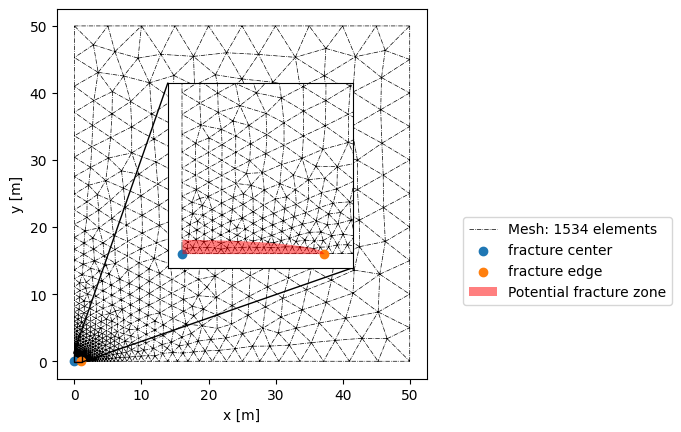

In [5]:
%matplotlib inline

fig, ax, _ = mesh.plot(triplot_kw=dict(
        label=f"Mesh: {mesh.number_els} elements"
))
zoom_xys = (
    (-fracture_radius/10, 1.2*fracture_radius),
    (-fracture_radius/10, 1.2*fracture_radius)
)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)

_x = np.linspace(0, fracture_radius)
_y = fracture_radius/10*np.sqrt(1-(_x/fracture_radius)**2)
for axis in (ax, axins):
    axis.scatter(*mesh.nodes[top_point], label="fracture center")
    axis.scatter(*mesh.nodes[right_point], label="fracture edge")
    axis.fill_between(_x, _y,
                      color='r', alpha=0.5,
                      zorder=4, linewidth=0,
                      label="Potential fracture zone")
ax.legend(loc=(1.1, 0.2))
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
plt.show()

## Matrix assembly

The problem is coupled: displacements and pore pressures interact. The fomer is evaluated through the stiffness matrix $\mathbf{K}$ and the latter through the conductivity matrix $\mathbf{C}$. The storage is denoted as $\mathbf{S}$.

To account for the interaction between stresses and pore pressure, the matrix should contain a hydro-mechanical coupling element. It is the matrix $\mathbf{A}$ wich depends on the time-step $\Delta t$.

In [6]:
S = MatrixAssembly.assemble_mass_matrix(mesh, 1/M)
C = MatrixAssembly.assemble_conductivity_matrix(mesh, kappa)
A = MatrixAssembly.assemble_coupling_matrix(mesh, alpha)
# Drained
K = MatrixAssembly.assemble_stiffness_matrix(mesh, E, nu)
# Undrained
K_u = MatrixAssembly.assemble_stiffness_matrix(mesh, E_u, nu_u)

ntot_E = mesh.number_nodes * 2
ntot_P = mesh.number_nodes
ntot = ntot_E + ntot_P

## Boundary conditions

To take advantage of the symmetry of the problem, only the upper-right quarter is modelled. The fixed rollers on the left and bottom parts of the rock mesh are an implication of said symmetry.

In [ ]:
tol = np.sqrt(width*height/mesh.number_els)/100

top = np.argwhere(np.isclose(mesh.nodes[:, 1], height, atol=tol))[:, 0]
left = np.argwhere(np.isclose(mesh.nodes[:, 0], 0, atol=tol))[:, 0]
right = np.argwhere(np.isclose(mesh.nodes[:, 0], width, atol=tol))[:, 0]
bottom = np.argwhere(
    np.isclose(mesh.nodes[:, 1], 0, atol=tol)
    & (mesh.nodes[:, 0] >= fracture_radius)
)[:, 0]
fracture = np.argwhere(
    np.isclose(mesh.nodes[:, 1], 0, atol=tol)
    & (mesh.nodes[:, 0] <= fracture_radius)
)[:, 0]

_, ax, _ = mesh.plot(triplot_kw=dict(ls='--', label='Mesh'), zorder=1)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)
for axe in (ax, axins):
    axe.scatter(*mesh.nodes[fracture].T, label="$\sigma_0$ & $p_w$")
    axe.scatter(*mesh.nodes[np.hstack((top, right))].T, label="$free$")
    pc = axe.scatter(*mesh.nodes[left].T, label="$u_x=0$", marker='>')
    axe.scatter(*mesh.nodes[bottom].T, marker="^", label="$u_y=0$")

ax.legend(loc=(1.1, 0.2))
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
plt.show()

## Pressure distribution

The applied pressure on the fracture wall has to be integrated over the surface. The `MatrixAssembly::assemble_traction_over_line` will do it for us. A possible check is the total force applied:

$$ F_{tot} = \int_S f dS = f\cdot\pi R^2\quad \text{For a constant load} $$

In [ ]:
%matplotlib inline

f = MatrixAssembly.assemble_tractions_over_line(mesh, fracture, [0, fracture_pressure, 0, 0])
# Cheating because there is a small error (10%)
f *= fracture_pressure * np.pi*fracture_radius**2 / f.reshape(2, -1, order='F')[1].sum()
fv = f.reshape(2, -1, order='F')

for s, direction in zip(fv, ("rr", "zz")):
    fig, ax, cb = mesh.plot(s)
    axins = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
    for axe in (ax, axins):
        vmin = vmax = None
        if s.min() == s.max():
            vmin, vmax = -1, 1
        axe.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], s, vmin=vmin, vmax=vmax)
    cb.mappable.set_clim(vmin=vmin, vmax=vmax)
    ax.set_title(rf"$\sigma_{{{direction}}}$")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    plt.show()

# Transient solution

### Time integration

An implicit scheme (backward Euler) is used as it doesn't require a small time-step and is first order accurate in time.

$$\Delta t \begin{pmatrix}\mathbf{\dot{u}}\\\mathbf{\dot{p}}\end{pmatrix}=\begin{pmatrix}\mathbf{u}^{n+1}\\\mathbf{p}^{n+1}\end{pmatrix}-\begin{pmatrix}\mathbf{u}^{n}\\\mathbf{p}^{n}\end{pmatrix}$$

$$ \begin{bmatrix} \mathbf{0} & \mathbf{0}\\\mathbf{0} & -\Delta t\mathbf{C} \end{bmatrix}\begin{pmatrix}\mathbf{u}^{n+1}\\\mathbf{p}^{n+1}\end{pmatrix} + \begin{bmatrix} \mathbf{K} & -\mathbf{A}\\-\mathbf{A}^\intercal & -\mathbf{S}\end{bmatrix}\begin{pmatrix}\Delta\mathbf{u}\\\Delta\mathbf{p}\end{pmatrix}=\Delta t\begin{pmatrix}\dot{\mathbf{f}}_t\\\mathbf{f}_q\end{pmatrix}$$

Where the incremental unknowns can be found by solving the following $\mathbf{Ax}=\mathbf{b}$ type system:

\begin{equation}\begin{bmatrix} \mathbf{K} & -\mathbf{A}\\-\mathbf{A}^\intercal & -\mathbf{S}-\Delta t\mathbf{C} \end{bmatrix}\begin{pmatrix}\Delta\mathbf{u}\\\Delta\mathbf{p}\end{pmatrix}=\Delta t\begin{pmatrix}\dot{\mathbf{f}}_t\\\mathbf{f}_q\end{pmatrix} + \begin{pmatrix}\mathbf{0}\\\Delta t\mathbf{C}\mathbf{p}^n\end{pmatrix}\tag{2}\end{equation}

### Undrained problem

To compute the undrained response, the whole traction forces are applied on a single time-step and the initial pore pressure $\mathbf{p}^{0}$ does not play a role in the solution.

\begin{equation}\begin{bmatrix} \mathbf{K} & -\mathbf{A}\\-\mathbf{A}^\intercal & -\mathbf{S} \end{bmatrix}\begin{pmatrix}\Delta\mathbf{u}\\\Delta\mathbf{p}\end{pmatrix}=\begin{pmatrix}\mathbf{f}_t\\0\end{pmatrix}\tag{3}\end{equation}

This system solves as:

$$ \left(\mathbf{K} + \mathbf{AS}^{-1}\mathbf{A^\intercal}\right)\Delta\mathbf{u} = \mathbf{f}_t \qquad \Delta p = -\mathbf{S}^{-1}\mathbf{A}^\intercal\Delta \mathbf{u} $$

NB: This solution is close to the purely mechanical undrained answer $\mathbf{K}_u\Delta\mathbf{u}=\mathbf{f}_t$ since $\mathbf{p}^0$ has no effect. Anyway, directly solving equation (3) is a simple computation.

In [ ]:
def fast_loading(force, eq_free_d, eq_free_p, time=time):

    dt = np.diff(time)
    eq_free = np.hstack((eq_free_d, eq_free_p + ntot_E))
    eq_fixed_p = np.setdiff1d(np.arange(ntot_P), eq_free_p) + ntot_E

    # we prepare the solution vectors
    solutions = np.zeros((time.size, ntot))

    # UNDRAINED bulk modulus
    # it's the drained one in the exercise corrections (wrong in my opinion)
    top_ma = sp.hstack((K_u, -A), format='csc')
    bottom_ma = sp.hstack((-A.T, - S), format='csc')
    T = sp.vstack((top_ma, bottom_ma), format='csc')

    undrained_sol = np.zeros(ntot)
    force_u = force.copy()
    force_u[ntot_E:] = 0  # from equation (2)
    undrained_sol[eq_free] = sp.linalg.spsolve(T[eq_free][:, eq_free], force_u[eq_free])
    undrained_sol[eq_fixed_p] = force[eq_fixed_p]
    solutions[0] = undrained_sol

    force_d = force.copy()
    # force vector: DIFFERENTIAL tractions => 0
    # it's the tractions in the exercise corrections (wrong in my opinion)
    force_d[:ntot_E] = 0
    top_ma = sp.hstack((K, -A), format='csc')  # DRAINED bulk modulus

    # Time integration loop
    for i, dti in enumerate(dt):
        print(f'Iteration {i + 1}/{dt.size} ({(i + 1)/dt.size:.0%})', end='\r')

        # update the conductivity in the matrix
        bottom_ma = sp.hstack((-A.T, -S - dti * C), format='csc')
        T = sp.vstack((top_ma, bottom_ma), format='csc')

        # update the pore pressure in the force vector
        pore_pressure_free = eq_free[eq_free >= ntot_E]
        flux = dti * C[pore_pressure_free - ntot_E] @ solutions[i, ntot_E:]
        force_d[pore_pressure_free] = flux

        # solve the system
        update = sp.linalg.spsolve(T[eq_free][:, eq_free], force_d[eq_free])
        solutions[i + 1, eq_free] = solutions[i, eq_free] + update
        solutions[i + 1, eq_free] = solutions[i, eq_free] + update
        # Setting the forced pressures in the solution (missing in the exercise corrections)
        solutions[i + 1, eq_fixed_p] = force_d[eq_fixed_p]
    print()

    displacement_field = solutions[:, :ntot_E].reshape(time.size, 2, mesh.number_nodes, order='F')
    p_field = solutions[:, ntot_E:]

    return displacement_field, p_field

# Impermeable walls

Here, a simple mechanical pressure is applied on the fracture wall. The fast loading function implemented above applies since the force is applied suddenly and then remains constant.

In [ ]:
%matplotlib inline
_, ax, _ = mesh.plot(triplot_kw=dict(ls='--', label='Mesh'), zorder=1)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)
for axe in (ax, axins):
    axe.scatter(*mesh.nodes[fracture].T, label=r"$\sigma=p_w\cdot n$")
    axe.scatter(*mesh.nodes[left].T, label="$u_x=0$", marker='>')
    axe.scatter(*mesh.nodes[bottom].T, label="$u_y$=0", marker='^')
    axe.scatter(*mesh.nodes[np.hstack((top, right))].T, label="Free")

ax.legend(loc=(1.1, 0.2))
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
plt.show()

In [ ]:
force = np.zeros(ntot)
force[:ntot_E] = f

dof_fixed = np.hstack((2*left, 2 * bottom + 1))
eq_free_d = np.setdiff1d(np.arange(ntot_E), dof_fixed)

eq_free_p = np.arange(ntot_P)

disp_imperm, pp_imperm = fast_loading(force, eq_free_d, eq_free_p)

In [ ]:
%matplotlib inline

fig, ax, cb = mesh.plot(pp_imperm[0], shading='flat')
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pp_imperm[0])
ax.set_title('$p_w$ (MPa)', loc='left')

fig, ax, cb = mesh.plot(disp_imperm[0, 0])
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], disp_imperm[0, 0])
ax.set_title('$u_x$ (m)', loc='left')

fig, ax, cb = mesh.plot(disp_imperm[0, 1])
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], disp_imperm[0, 1])
ax.set_title('$u_y$ (m)', loc='left')

factor = 0.2/np.abs(disp_imperm[0]).max()
# d_field[0] = np.ones_like(d_field[0])
fig, ax, cb = mesh.plot(factor * np.linalg.norm(disp_imperm[0], axis=0))
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], np.linalg.norm(disp_imperm[0], axis=0))
for axe in (ax, axin):
    axe.triplot(*(mesh.nodes.T + factor * disp_imperm[0]), c='r', lw=0.5, zorder=4)
cb.ax.set_ylabel(f"[m] (x{factor:.0f})")
ax.set_title(f'deformed mesh ({factor:.0e} x multiplication) ', loc='left')

In [ ]:
%matplotlib qt

vmax = np.abs(pp_imperm).max()

# setting up the figure
fig, ax = plt.subplots()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3],
                  pp_imperm[0],
                  vmin=-vmax, vmax=vmax,
                  lw=1, shading='gouraud', cmap='RdBu')
timetxtr = ax.set_title('t=0', loc='right')
timetxtl = ax.set_title(f"|{' ':<10}|", loc='left')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.colorbar(im).ax.set_ylabel("$p_w$ [MPa]")
ax.set_aspect(1)
mesh.plot(ax=ax)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)
imz = axins.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3],
                       pp_imperm[0],
                       vmin=-vmax, vmax=vmax,
                       lw=1, shading='gouraud', cmap='RdBu')

def update(i):
    timetxtr.set_text(f'$p_w^{{e}}$(t={time[i]:.0e} s)')
    timetxtl.set_text(f"|{'█'*((i+1)*10//time.size):░<10}| {((i+1)/time.size):.0%}")
    im.set_array(pp_imperm[i])
    imz.set_array(pp_imperm[i])
    return im, time

anim = FuncAnimation(fig, update, frames=time.size, interval=300/time.size)

In [ ]:
%matplotlib qt 

fig, ax = plt.subplots()
timetxtr = ax.set_title('t=0', loc='right')
timetxtl = ax.set_title(f"|{' ':<10}|", loc='left')
plt.colorbar(im)
ax.set_aspect(1)
mesh.plot(ax=ax)
# axins = mesh.zoom_plot(zoom_xys=((-0.05, 0.1), (-0.05, 0.1)))
axins = mesh.zoom_plot(zoom_xys=zoom_xys)

factor = 0.2/np.abs(disp_imperm).max()
nodes = mesh.nodes.T + factor * disp_imperm[0]
edges, _ = ax.triplot(*nodes, c='r', lw=0.5)
point_top = ax.scatter(*nodes[:, top_point], label="fracture center", zorder=edges.get_zorder()+1)
point_right = ax.scatter(*nodes[:, right_point], label="fracture edge", zorder=edges.get_zorder()+1)

edgesz, _ = axins.triplot(*nodes, c='r', lw=0.5)
point_topz = axins.scatter(*nodes[:, top_point], label="fracture center", zorder=edges.get_zorder()+1)
point_rightz = axins.scatter(*nodes[:, right_point], label="fracture edge", zorder=edges.get_zorder()+1)

def update(i):
    timetxtr.set_text(f'$u(t={time[i]:.0e} s)$ (x{factor:.0e})')
    timetxtl.set_text(f"|{'█'*((i+1)*10//time.size):░<10}|")
    nodes = mesh.nodes.T + factor * disp_imperm[i]
    line, _ = ax.triplot(*nodes, c='none')

    point_top.set_offsets(nodes[:, top_point])
    point_right.set_offsets(nodes[:, right_point])
    edges.set_data(*line.get_data())

    point_topz.set_offsets(nodes[:, top_point])
    point_rightz.set_offsets(nodes[:, right_point])
    edgesz.set_data(*line.get_data())

anim = FuncAnimation(fig, update, frames=time.size, interval=300/time.size)

# Permeable walls

Now, both mechanical and pore pressure are applied.

Existential question : should the mechanical pressure reduce over time ? Since the pore pressure gradient at the fracture goes to zero with time, I'd expect the mechanical action to go to zero too. But, there's no more time for me to implement it. Although it might just be $\dot{\mathbf{f}}_t = \Delta\mathbf{p}_w^\text{fracture}$ in the solution of equation (2).

In [ ]:
%matplotlib inline

_, ax, _ = mesh.plot(triplot_kw=dict(ls='--', label='Mesh'), zorder=1)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)
for axe in (ax, axins):
    axe.scatter(*mesh.nodes[fracture].T, label=r"$p=p_w$""\n"r"$\sigma=p_w\cdot n$")
    axe.scatter(*mesh.nodes[left].T, label="$u_x=0$", marker='>')
    axe.scatter(*mesh.nodes[bottom].T, label="$u_y$=0", marker='^')
    axe.scatter(*mesh.nodes[np.hstack((top, right))].T, label="Free")

ax.legend(loc=(1.1, 0.2))
plt.show()

In [ ]:
force = np.zeros(ntot)
force[:ntot_E] = f
force[ntot_E + fracture] = fracture_pressure

dof_fixed = np.hstack((2*left, 2 * bottom + 1))
eq_free_d = np.setdiff1d(np.arange(ntot_E), dof_fixed)

eq_free_p = np.setdiff1d(np.arange(ntot_P), fracture)

disp_perm, pp_perm = fast_loading(force, eq_free_d, eq_free_p)

In [ ]:
%matplotlib inline

fig, ax, cb = mesh.plot(pp_perm[0], shading='flat')
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pp_perm[0])
ax.set_title("$p_w$ (MPa)", loc="left")

fig, ax, cb = mesh.plot(disp_perm[0, 0])
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], disp_perm[0, 0])
ax.set_title('$u_x$ (m)', loc='left')

fig, ax, cb = mesh.plot(disp_perm[0, 1])
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], disp_perm[0, 1])
ax.set_title('$u_y$ (m)', loc='left')

factor = 0.2/np.abs(disp_perm[0]).max()
# d_field[0] = np.ones_like(d_field[0])
fig, ax, cb = mesh.plot(factor * np.linalg.norm(disp_perm[0], axis=0))
axin = mesh.zoom_plot(ax=ax, zoom_xys=zoom_xys)
axin.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], np.linalg.norm(disp_perm[0], axis=0))
for axe in (ax, axin):
    axe.triplot(*(mesh.nodes.T + factor * disp_perm[0]), c='r', lw=0.5, zorder=4)
cb.ax.set_ylabel(f"[m] (x{factor:.0f})")
ax.set_title(f'deformed mesh ({factor:.0e} x multiplication) ', loc='left')

In [ ]:
%matplotlib qt

vmax = np.abs(pp_imperm).max()

# setting up the figure
fig, ax = plt.subplots()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3],
                  pp_imperm[0],
                  vmin=-vmax*3, vmax=vmax*3,
                  lw=1, shading='gouraud', cmap='RdBu')
timetxtr = ax.set_title('t=0', loc='right')
timetxtl = ax.set_title(f"|{' ':<10}|", loc='left')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.colorbar(im).ax.set_ylabel("$p_w$ [MPa]")
ax.set_aspect(1)
mesh.plot(ax=ax)
axins = mesh.zoom_plot(zoom_xys=zoom_xys)
imz = axins.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3],
                       pp_perm[0],
                       vmin=-vmax*3, vmax=vmax*3,
                       lw=1, shading='gouraud', cmap='RdBu')

def update(i):
    timetxtr.set_text(f'$p_w^{{e}}$(t={time[i]:.0e}) s')
    timetxtl.set_text(f"|{'█'*((i+1)*10//time.size):░<10}| {((i+1)/time.size):.0%}")
    im.set_array(pp_perm[i])
    imz.set_array(pp_perm[i])
    return im, time

anim = FuncAnimation(fig, update, frames=time.size, interval=300/time.size)

In [ ]:
%matplotlib qt 

fig, ax = plt.subplots()
timetxtr = ax.set_title('t=0', loc='right')
timetxtl = ax.set_title(f"|{' ':<10}|", loc='left')
plt.colorbar(im)
ax.set_aspect(1)
mesh.plot(ax=ax)
# axins = mesh.zoom_plot(zoom_xys=((-0.05, 0.1), (-0.05, 0.1)))
axins = mesh.zoom_plot(zoom_xys=zoom_xys)

nodes = mesh.nodes.T + factor * disp_imperm[0]
edges, _ = ax.triplot(*nodes, c='r', lw=0.5)
point_top = ax.scatter(*nodes[:, top_point], label="fracture center", zorder=edges.get_zorder()+1)
point_right = ax.scatter(*nodes[:, right_point], label="fracture edge", zorder=edges.get_zorder()+1)

edgesz, _ = axins.triplot(*nodes, c='r', lw=0.5)
point_topz = axins.scatter(*nodes[:, top_point], label="fracture center", zorder=edges.get_zorder()+1)
point_rightz = axins.scatter(*nodes[:, right_point], label="fracture edge", zorder=edges.get_zorder()+1)

def update(i):
    timetxtr.set_text(f'$u(t={time[i]:.0e})$ (x{factor:.0e})')
    timetxtl.set_text(f"|{'█'*((i+1)*10//time.size):░<10}|")
    nodes = mesh.nodes.T + factor * disp_imperm[i]
    line, _ = ax.triplot(*nodes, c='none')

    point_top.set_offsets(nodes[:, top_point])
    point_right.set_offsets(nodes[:, right_point])
    edges.set_data(*line.get_data())

    point_topz.set_offsets(nodes[:, top_point])
    point_rightz.set_offsets(nodes[:, right_point])
    edgesz.set_data(*line.get_data())

anim = FuncAnimation(fig, update, frames=time.size, interval=300/time.size)

## Results and discussion
# Comparison with the analytical solution

Tada's book gives an analytical solution to the **elastic** problem:

$$ w_f = \frac{8\sigma}{\pi E'}R $$

where $E'$ is the appropriate Young modulus, $\sigma$ the applied pressure on the fracture and $R$ the fracture's radius.

In [ ]:
%matplotlib inline
zi = disp_imperm[:, 1][:, top_point]
zp = disp_perm[:, 1][:, top_point]
with plt.style.context('ggplot'):
    plt.title("Fracture width evolution")
    # Impermeable
    plt.plot(time, 2*zi, "o", label="Impermeable", mfc='w', mew=1.5, c='gray')
    # Permeable
    plt.plot(time, 2*zp, "o", label="Permeable", ms=2, mew=1.5, c='teal')
    # Analytical
    plt.axline((0, 8*fracture_pressure/np.pi/E_u), slope=0, ls='--', c='r', lw=1, label="Undrained")
    plt.axline((0, 8*fracture_pressure/np.pi/E), slope=0, ls='-.', c='b', lw=1, label="Drained")

    plt.xlabel("$t$ [s]")
    plt.ylabel("$z$ [m]")
    plt.gca().dataLim.y0 = 0
    plt.gca().dataLim.y1 = 2*(zp.min() + zp.max())
    plt.semilogx()
    plt.legend()

In the figure above, we can see the undrained answer being lower than expected. This is certainly because of the water pressure on top of the fracture resisting the movement (the positive pore pressure seen in pore water pressure above the fracture in the plots). 

After some time, the fracture moves again. It happens once the pore pressure is dissipated to the rest of the mesh. The difference amplitude of the displacement between the drained and undrained states $w_f^\text{drained}-w_f^\text{undrained}$ seems so be identical in this numerical solution and in Tada's analytical solution.

The shape of the fracture's deformation is an ellipsis, meaning that the width of the fracture at any distance $r$ from the welbore axis is:
$$ w(r) = w_f\sqrt{1-\frac{r^2}{R^2}} $$

NB: the actual width is twice the width computed above since only the top is modelled.

In [ ]:
%matplotlib inline
x = np.linspace(0, fracture_radius)
r_up, z_up = mesh.nodes[fracture].T + disp_perm[0][:, fracture]
rp, zp = mesh.nodes[fracture].T + disp_perm[-1][:, fracture]
r_ui, z_ui = mesh.nodes[fracture].T + disp_imperm[0][:, fracture]
ri, zi = mesh.nodes[fracture].T + disp_imperm[-1][:, fracture]
dz_u = 8*fracture_pressure/np.pi/E_u * np.sqrt(1-(x/fracture_radius)**2)
dz = 8*fracture_pressure/np.pi/E * np.sqrt(1-(x/fracture_radius)**2)
with plt.style.context('ggplot'):
    plt.title("Fracture shape")
    # Impermeable
    plt.plot(r_up, 2*z_up, "o", label="Undrained permeable", mfc='w', mew=1.5)
    plt.plot(rp, 2*zp, "o", label="Drained permeale", mfc='w', mew=1.5)
    # Permeable
    plt.plot(r_ui, 2*z_ui, "o", label="Undrained impermeable", ms=2, mew=1.5)
    plt.plot(ri, 2*zi, "o", label="Drained impermeale", ms=2, mew=1.5)
    # Analytical
    plt.plot(x, dz_u, '--', label="Tada: undrained", lw=1)
    plt.plot(x, dz, '--', label="Tada: drained", lw=1)

    plt.xlabel("$r$ [m]")
    plt.ylabel("$z$ [m]")
    plt.legend()

In [ ]:
with plt.style.context('ggplot'):
    for pp, kind in zip((pp_perm, pp_imperm), ("Permeable", "Impermeable")):

        # Get the information on the pore pressure field.
        mean = pp.mean(axis=1)
        std = pp.std(axis=1)
        max = pp.max(axis=1)
        min = pp.min(axis=1)

        c = plt.plot(time, mean, label=f"{kind}: mean")[0].get_color()
        plt.fill_between(time, mean - std, mean + std, alpha=0.3, fc=c, label=f"{kind}: $\pm$ std enveloppe")
        plt.fill_between(time, min, max, alpha=0.2, fc=c, label=f"{kind}: maxima enveloppe")
        plt.xlabel('time [s]')
        plt.ylabel('Pressure [MPa]')
        plt.semilogx()
    plt.legend(loc="lower right")
    plt.title("Pore pressure distribution (over the whole mesh)")

We can see that the pressure diffusion preceeds with the restart of the displacements (starts at $t=10^4$ s vs. $t=10^8$ s) and that the simulation approached some drained solution in both cases:
- Impermeable walls: the pore pressure dissipates and goes to zero in the long term
- Permeable walls: the pore pressure diffuses and stabilizes at the fracture pressure in the long term